In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/misc-tools/pyplot_tool/')
import plot_tools
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/mixqtl-gtex/postprocessing/functional_enrichment/')
import functional_enrichment
import io
import subprocess
import os

In [2]:
def merge(df, dfn, extract_col_dict, by_cols):
    tmp = dfn[list(extract_col_dict.keys()) + by_cols]
    tmp = tmp.rename(columns=extract_col_dict)
    if df is None:
        return tmp
    else:
        return pd.merge(df, tmp, on=by_cols)
def trim_dot(dd):
    return [ i.split('.')[0] for i in dd ]

def get_pval_mixqtl(p1, p2, p3):
    o = p1.copy()
    o[np.isnan(o)] = p2[np.isnan(o)]
    o[np.isnan(o)] = p3[np.isnan(o)]
    return o
def rename_col(df, method):
    if method == 'rasqual':
        return df.rename(columns={'Feature_ID': 'phenotype_id', 'rs_ID': 'variant_id'})
    elif method == 'eqtl':
        if 'gene_id' in df.columns:
            df['gene_id'] = trim_dot(df['gene_id'])
        return df.rename(columns={'gene_id': 'phenotype_id', 'pval_nominal': 'pval', 'slope': 'bhat'})
    elif method == 'mixqtl':
        return df
def clean_up_rasqual(df):
    # clean up rasqual
    tmp = df
    tmp = tmp[ tmp['Convergence_status_0success'] == 0 ].reset_index(drop=True)

    tmp['pval'] = scipy.stats.chi2.sf(tmp['Chi_square_statistic_2_x_log_Likelihood_ratio'], 1)
    tmp['bhat'] = np.log(tmp.Effect_size_Pi / (1 - tmp.Effect_size_Pi))
    df = rename_col(tmp, 'rasqual')
    df = df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    return df
def clean_up(df, method):
    df = rename_col(df, method)
    if method == 'mixqtl':
        # clean up mixqtl
        tmp = df
        tmp['pval'] = get_pval_mixqtl(tmp.pval_meta, tmp.pval_trc, tmp.pval_asc)
        tmp['bhat'] = get_pval_mixqtl(tmp.beta_meta, tmp.beta_trc, tmp.beta_asc)
        return tmp[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'eqtl':
        # clean up eqtl
        return df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'rasqual':
        return clean_up_rasqual(df)
def read_from_cmd(cmd, kwargs={}):
    print(cmd)
    process = subprocess.check_output([cmd], stderr=subprocess.STDOUT, shell=True)
    csv = io.StringIO()
    for line in process.decode().split('\n'):
        csv.write(line.strip('"\n') + '\n')
    csv.seek(0)
    data = pd.read_csv(csv, **kwargs)
    csv.close()
    return data

In [3]:
file = {}
file['rasqual'] = '/home/t.cri.yliang/scratch/run-rasqual-results/kidney_cortex/rasqual_output.Kidney_Cortex.chr{chr_num}.parquet'
file['mixqtl'] = '/home/t.cri.yliang/scratch/mixQTL-GTExV8/mixqtl/Kidney_Cortex/mixqtl.Kidney_Cortex_GTEx_eGene.cis_qtl_pairs.mixQTL.chr{chr_num}.parquet'
file['eqtl'] = '/home/t.cri.yliang/scratch/mixQTL-GTExV8/split_eqtl/Kidney_Cortex/eqtl_allpairs.chr{chr_num}.parquet'
chrs = [ i for i in range(1, 23) ]

cache_file = 'cache_results_on_kidney_cortex.pkl.gz'

In [4]:
# get the list of variants
df_pairs = {}
for chr_num in chrs:
    fn = file['rasqual']
    fn = fn.format(chr_num=chr_num)
    dd = pd.read_parquet(fn)
    df_pairs[chr_num] = clean_up_rasqual(dd)

/home/t.cri.yliang/miniconda2/envs/mixqtl/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


In [5]:
import gzip
import pickle
if not functional_enrichment.file_exists(cache_file):
    df = {}

    for i, fn in file.items():
        print(i)
        df[i] = []
        for chr_num in chrs:
            print(f'chr{chr_num} \r', end='')
            fn = file[i]
            fn = fn.format(chr_num=chr_num)
            tmp = pd.read_parquet(fn)
            tmp = rename_col(tmp, i)
            tmp = pd.merge(df_pairs[chr_num][['phenotype_id', 'variant_id']], tmp, on=['phenotype_id', 'variant_id'])
            tmp = clean_up(tmp, i)
            df[i].append(tmp)
        df[i] = pd.concat(df[i], axis=0)
        print('\n')
    with gzip.open(cache_file, 'wb') as f:
        pickle.dump(df, f)
else:
    with gzip.open(cache_file, 'rb') as f:
        df = pickle.load(f)

In [6]:
# merge all three
df_p = None
df_b = None
df_p = merge(df_p, df['rasqual'], extract_col_dict={'pval': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['mixqtl'], extract_col_dict={'pval': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['eqtl'], extract_col_dict={'pval': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['rasqual'], extract_col_dict={'bhat': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['mixqtl'], extract_col_dict={'bhat': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['eqtl'], extract_col_dict={'bhat': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])

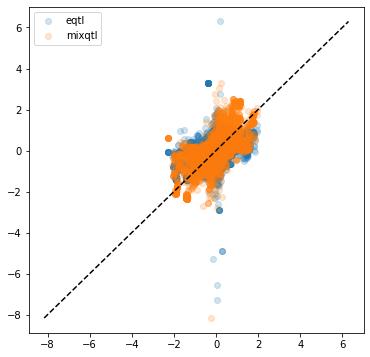

In [7]:
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [df_b['rasqual'], df_b['rasqual']],
    [df_b['eqtl'], df_b['mixqtl']],
    ['eqtl', 'mixqtl'],
    axe,
    {'alpha': 0.2}
)

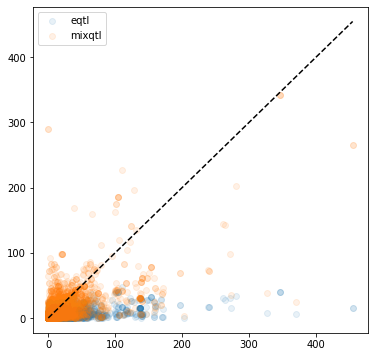

In [8]:
# subset
ind_sub = np.random.randint(0, df_p.shape[0], size=50000)
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ -np.log(df_p['rasqual'][ind_sub]), -np.log(df_p['rasqual'][ind_sub]) ],
    [ -np.log(df_p['eqtl'][ind_sub]), -np.log(df_p['mixqtl'][ind_sub]) ],
    ['eqtl', 'mixqtl'],
    axe,
    {'alpha': 0.1}
)

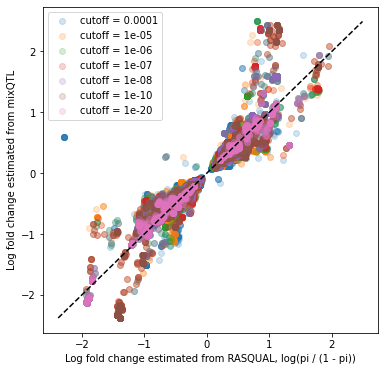

In [10]:
# both signif
inds = []
cutoffs = [ 1e-20, 1e-10, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4 ]
for cutoff in cutoffs:
    if len(inds) > 0:
        inds.append(~inds[-1] & (df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff))
    else:
        inds.append((df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff))

fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ df_b['rasqual'][ind] for ind in reversed(inds) ],
    [ df_b['mixqtl'][ind] for ind in reversed(inds) ],
    [ 'cutoff = {}'.format(co) for co in reversed(cutoffs) ],
    axe,
    {'alpha': 0.2}
)
axe.set_xlabel('Log fold change estimated from RASQUAL, log(pi / (1 - pi))')
axe.set_ylabel('Log fold change estimated from mixQTL')
fig.savefig("effect_size_kidney_cortex_100kb.png",dpi=(250), bbox_inches='tight')

In [ ]:
# tmp = df_b[ (df_p.rasqual < 1e-5) & (df_p.mixqtl < 1e-5)]
# tmp2 = tmp[ (tmp.rasqual < 0) & (tmp.mixqtl > 0) | (tmp.rasqual > 0) & (tmp.mixqtl < 0) ]

In [ ]:
# tmp2

In [ ]:
# tmp = pd.read_parquet(file['rasqual'].format(chr_num=1))

In [ ]:
# tmp = pd.merge(tmp, tmp2, left_on=['Feature_ID', 'rs_ID'], right_on=['phenotype_id', 'variant_id'])

In [ ]:
# tmp.Reference_allele_mapping_bias_Phi

In [ ]:
# tmp[ (tmp.Feature_ID == 'ENSG00000072163') & (tmp.rs_ID == 'chr2_127648067_C_T_b38')].columns

In [ ]:
# tmp[ (tmp.Feature_ID == 'ENSG00000072163') & (tmp.rs_ID == 'chr2_127648067_C_T_b38')][['Chi_square_statistic_2_x_log_Likelihood_ratio', 'Effect_size_Pi']]

In [ ]:
# tmp[ (tmp.Feature_ID == 'ENSG00000072163') & (tmp.rs_ID == 'chr2_127648067_C_T_b38')][['rs_ID', 'Ref_allele', 'Alt_allele', 'Reference_allele_mapping_bias_Phi']]

In [ ]:
# a1 = pd.read_csv('/scratch/t.cri.yliang/mixQTL-GTExV8/preprocessing/prepare_data/Kidney_Cortex/allele_specific_count.hap1.txt.gz', compression='gzip', sep='\t')
# a2 = pd.read_csv('/scratch/t.cri.yliang/mixQTL-GTExV8/preprocessing/prepare_data/Kidney_Cortex/allele_specific_count.hap2.txt.gz', compression='gzip', sep='\t')
# a1 = a1[ a1.GENE_ID == 'ENSG00000072163' ]
# a2 = a2[ a2.GENE_ID == 'ENSG00000072163' ]

In [ ]:
# hap1 = pd.read_parquet('/home/t.cri.yliang/scratch/gtexv8_genotype_in_parquet/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01.chr2.hap1.parquet')
# hap2 = pd.read_parquet('/home/t.cri.yliang/scratch/gtexv8_genotype_in_parquet/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01.chr2.hap2.parquet')
# hap1 = hap1[ hap1.index == 'chr2_127648067_C_T_b38']
# hap2 = hap2[ hap2.index == 'chr2_127648067_C_T_b38']

In [ ]:
# hap1 = hap1[ a1.columns[1:] ] 
# hap2 = hap2[ a2.columns[1:] ] 

In [ ]:
# hap1[ 'GTEX-11TTK' ]

In [ ]:
# hap2[ 'GTEX-11TTK' ]

In [ ]:
# geno = np.array([ '{}{}'.format(i, j) for i, j in zip(hap1.values.tolist()[0], hap2.values.tolist()[0]) ])

In [ ]:
# ratio = a1.iloc[:, 1:].values / a2.iloc[:, 1:].values

In [ ]:
# ratio = ratio[0]
# ratio[np.isnan(ratio)] = 1

In [ ]:
# plt.boxplot([ratio[geno == '10'], ratio[geno == '00'], ratio[geno == '11'], ratio[geno == '01']])

In [ ]:
# cmd = '/gpfs/data/im-lab/nas40t2/yanyul/softwares/miniconda2/envs/mixqtl/bin/tabix /scratch/t.cri.yliang/run-rasqual-results/kidney_cortex/bgz_rasqual_Kidney_Cortex.chr2.vcf.gz "2:127638381-127681786"'
# rfile = read_from_cmd(cmd, {'sep': '\t', 'header': None})

In [ ]:
# cmd = '/gpfs/data/im-lab/nas40t2/yanyul/softwares/miniconda2/envs/mixqtl/bin/tabix /scratch/t.cri.yliang/run-rasqual-results/kidney_cortex/bgz_rasqual_Kidney_Cortex.chr2.vcf.gz "2:127648067-127648067"'
# gfile = read_from_cmd(cmd, {'sep': '\t', 'header': None})

In [ ]:
# gfile

In [ ]:
# cmd = 'zcat /scratch/t.cri.yliang/run-rasqual-results/kidney_cortex/bgz_rasqual_Kidney_Cortex.chr2.vcf.gz | head -n 1'
# rfile_h = read_from_cmd(cmd, {'sep': '\t', 'header': None})

In [ ]:
# rfile.columns = rfile_h.iloc[0, :].values.tolist()
# gfile.columns = rfile_h.iloc[0, :].values.tolist()

In [ ]:
# def parser(ss):
#     geno, asc = ss.split(':')
#     h1, h2 = geno.split('|')
#     if geno == '0|1':
#         a1, a2 = asc.split(',')
#     elif geno == '1|0':
#         a2, a1 = asc.split(',')
#     else:
#         a1 = 0
#         a2 = 0
    
#     return int(clean_dot(h1)), int(clean_dot(h2)), int(clean_dot(a1)), int(clean_dot(a2))
# def clean_dot(ss):
#     if ss == '.':
#         return 0
#     else:
#         return ss
# mat_a1 = np.zeros((rfile.shape[0], rfile.shape[1] - 9))
# mat_a2 = np.zeros((rfile.shape[0], rfile.shape[1] - 9))
# for i in range(rfile.shape[0]):
#     for j in range(rfile.shape[1] - 9):
#         ss = rfile.iloc[i, j + 9]
#         _, _, a11, a12 = parser(str(ss))
#         mat_a1[i, j] = a11
#         mat_a2[i, j] = a12
# mat_g1 = np.zeros((gfile.shape[0], gfile.shape[1] - 9))
# mat_g2 = np.zeros((gfile.shape[0], gfile.shape[1] - 9))
# for i in range(gfile.shape[0]):
#     for j in range(gfile.shape[1] - 9):
#         ss = gfile.iloc[i, j + 9]
#         g11, g12, _, _ = parser(str(ss))
#         mat_g1[i, j] = g11
#         mat_g2[i, j] = g12
                

In [ ]:
# asc1 = mat_a1.sum(axis=0)
# asc2 = mat_a2.sum(axis=0)

In [ ]:
# asc2

In [ ]:
# a2[ rfile.columns[9:] ]

In [ ]:
# asc1

In [ ]:
# a1[ rfile.columns[9:] ]

In [ ]:
# mat_g1.astype(int)

In [ ]:
# mat_g2.astype(int)

In [ ]:
# geno2 = np.array([ '{}{}'.format(i, j) for i, j in zip(mat_g1.astype(int).tolist()[0], mat_g2.astype(int).tolist()[0]) ])

In [ ]:
# ratio2 = asc1 / asc2
# ratio2[np.isnan(ratio2)] = 1

In [ ]:
# ratio2

In [ ]:
# ratio

In [ ]:
# plt.boxplot([ratio2[geno2 == '10'], ratio2[geno2 == '00'], ratio2[geno2 == '11'], ratio2[geno2 == '01']])

In [ ]:
# a1[rfile.columns[9:]]

In [ ]:
# a2[rfile.columns[9:]]

In [ ]:
# asc1

In [ ]:
# asc2

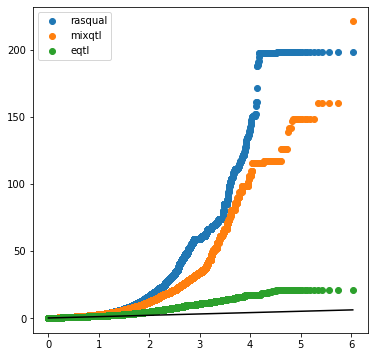

In [11]:
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.qqplot(
    [df_p['rasqual'], df_p['mixqtl'], df_p['eqtl']],
    ['rasqual', 'mixqtl', 'eqtl'],
    axe
)
fig.savefig("qqplot_kidney_cortex_100kb.png",dpi=(250), bbox_inches='tight')